# Mask R-CNN - Train on Custom Wolves Dataset


This notebook shows how to train Mask R-CNN on a custom dataset. We will use a custom dataset containing images of Wolves.

In [1]:
# import the essential libraries
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Root directory of the project
ROOT_DIR = os.path.abspath(r"./")

# For finding local version of the library
sys.path.append(ROOT_DIR)

# Importing Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import json
from sklearn import metrics
import skimage
%matplotlib inline 

# Directory for saving logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# path of COCO dataset
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "coco_model\mask_rcnn_coco.h5")
# Download the dataset if dataset does not exist.
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations for Training the Images

In [2]:
class WolvesConfig(Config):
    """Configuration for training the images
    """
    # Specifying name of the configuration
    NAME = "Wolves"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes including background
    NUM_CLASSES = 1 + 1  # wolves + background

    # Defining the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors as the images and the objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # Reduce training ROIs per image as the images and objects are small.
    # Allowing ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Using a small epoch size
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = WolvesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
# Code for Customdataset class.
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        # Adding classes
        self.add_class("object", 1, "Wolf")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        if subset == 'train':
            # Annotations for the train images
            annotations1 = json.load(open(r'dataset\train\wolf_t.json'))
            annotations = list(annotations1.values()) 

            # Skip unannotated images.
            annotations = [a for a in annotations if a['regions']]
        else:
            # Annotations for the validation dataset
            annotations1 = json.load(open(r'dataset\val\wolf_v.json'))
            annotations = list(annotations1.values())

            # Skip unannotated images.
            annotations = [a for a in annotations if a['regions']]
        
        # Adding images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Wolf": 1}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # using filename as unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [4]:
def get_ax(rows=1, cols=1, size=16):
    """
    TO DO:
    To control the size of rendered images
    
    Return:
    a Matplotlib Axes array to be used in all visualizations in the notebook. 
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [5]:
DATA_ROOT_DIR = r'dataset'

# Training dataset
dataset_train = CustomDataset()
dataset_train.load_custom(DATA_ROOT_DIR, 'train')
dataset_train.prepare()


# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(DATA_ROOT_DIR, 'val')
dataset_val.prepare()

objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wolf']
numids [1]
objects: ['Wol

In [6]:
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 40
Classes: ['BG', 'Wolf']


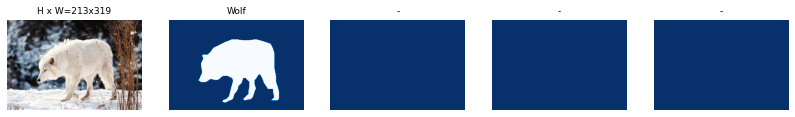

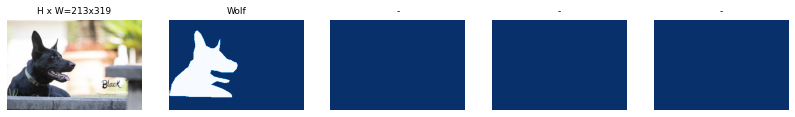

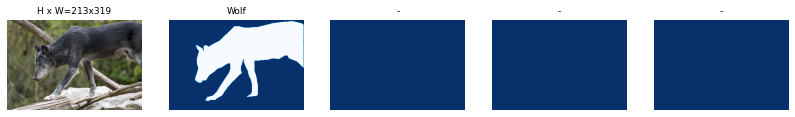

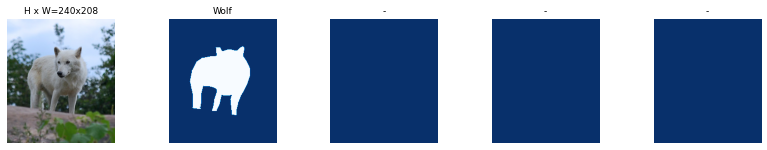

In [7]:
# Load and display random samples
img_ids = np.random.choice(dataset_train.image_ids, 4)
for img_id in img_ids:
    image = dataset_train.load_image(img_id)
    mask, class_ids = dataset_train.load_mask(img_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Building a Model

In [8]:
# Creating a model in training mode
model = modellib.MaskRCNN(mode="training", config = config, model_dir = MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
# selecting the weights to start with
# coco - loading the weights trained on MS COCO
# trained_model - loading the last trained model and start training
select_model_weights = "coco" 

if select_model_weights == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif select_model_weights == "trained_model":
    model.load_weights(model.find_last(), by_name=True)

## Training

In [10]:
# Training only the head layer and freezing the other layers.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\ACER\workspace\currently_working\olivia\wolves\logs\wolves20221229T1315\mask_rcnn_wolves_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

In [11]:
# training all the layers
"""model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, 
            layers="all")"""

'model.train(dataset_train, dataset_val, \n            learning_rate=config.LEARNING_RATE / 10,\n            epochs=3, \n            layers="all")'

In [12]:
# Saving the weights
# Generally it is not needed as callbacks save weights
# after every epoch.
trained_model_path = os.path.join(MODEL_DIR, "mask_rcnn_wolves.h5")
model.keras_model.save_weights(trained_model_path)

## Detection

In [13]:
# Configuration for the inference
class InferenceConfig(WolvesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# loading the trained weights

print('Loading model...')
model.load_weights(trained_model_path, by_name=True)
print('Model has been loaded.')

Instructions for updating:
Use tf.cast instead.
Loading model...
Model has been loaded.


**Original Image with Label before Prediction**

original_image           shape: (128, 128, 3)         min:    0.00000  max:  252.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  319.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   23.00000  max:  105.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  uint8


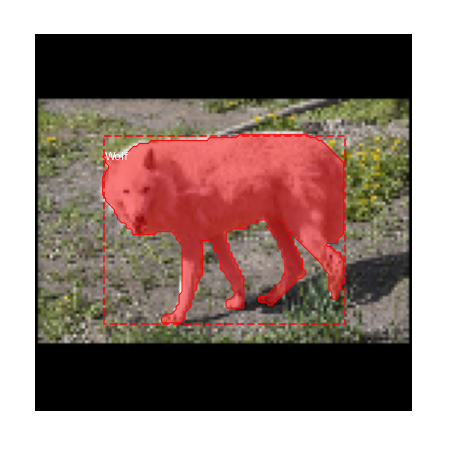

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

**Image after Prediction**

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


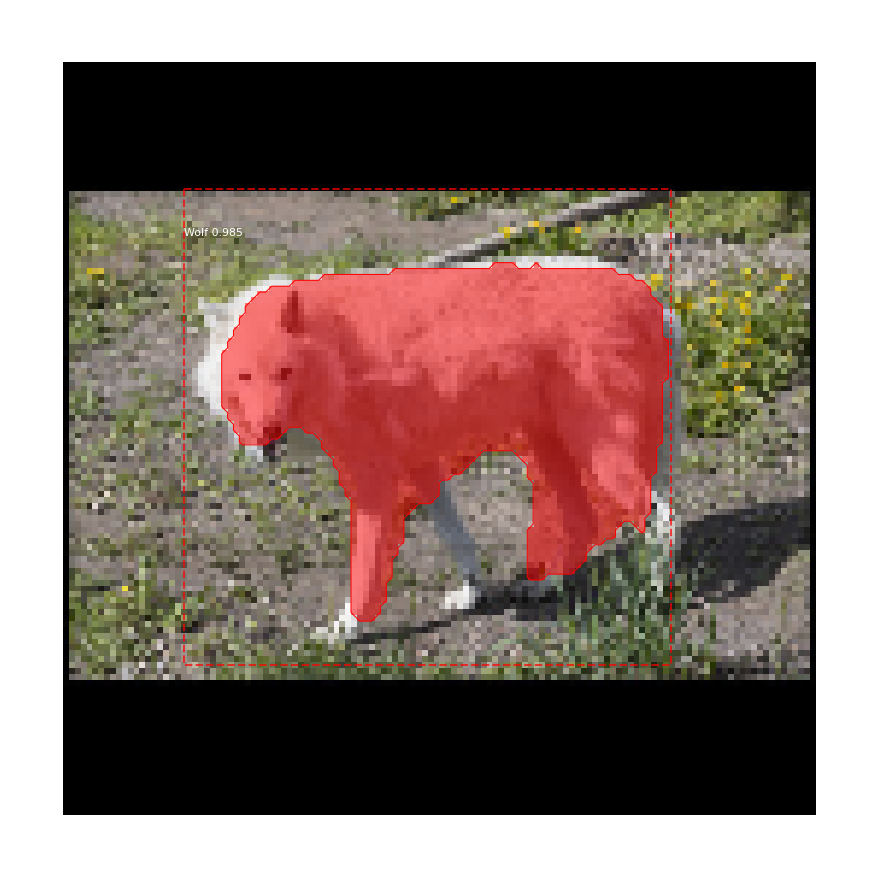

In [15]:
# object detection
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

**Mean Average Precision**

In [16]:
# For the ten images only
#image_ids = np.random.choice(dataset_val.image_ids, 10)

# for all the images
image_ids = dataset_val.image_ids

average_precisions = []
for image_id in image_ids:
    # Loading the image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # detecting object
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute Average Precision
    average_precision, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    average_precisions.append(average_precision)
    
print("Mean Average Precision: ", np.mean(average_precisions))

Mean Average Precision:  0.975


**Mean Average Precision in details**

In [18]:
import utils_2 as ut

# to store total ground truth values and total prediction values
actual_values = np.array([]) 
predicted_values = np.array([])

# to store mean average precisions
mean_average_precisions_ = []

# computing total ground truth, total predictions, and mean average precision
# for each image in the test/validation dataset
for image_id in dataset_val.image_ids:
    # use_mini_mask is false
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id)

    # Perform the detection
    results = model.detect([image], verbose=1)
    r = results[0]
    
    # calculate ground truth total and total prediction
    actual_value, pred = ut.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    actual_values = np.append(actual_values, actual_value)
    predicted_values = np.append(predicted_values, pred)
    
    # get AP, precision, recall
    average_precision_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("Actual length of the ground truth vector : ", len(actual_values))
    print("Actual length of the predicted vector : ", len(predicted_values))
    
    mean_average_precisions_.append(average_precision_)
    print("Average precision of this image : ", average_precision_)
    print("Actual mean average precision for the whole images : ", sum(mean_average_precisions_)/len(mean_average_precisions_))

actual_values = actual_values.astype(int)
predicted_values = predicted_values.astype(int)


# save the ground truth and prediction vectors
OUTPUT_DIR = "output"
ground_truths_and_predictions_json = {"Actual Values" : actual_values, "Predicted Values" : predicted_values}
df = pd.DataFrame(ground_truths_and_predictions_json)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# Saving the result as dataframe
df.to_csv(f'{OUTPUT_DIR}/wolves_pred.csv', index = False)

# Saving the result as json
df.to_json(os.path.join(OUTPUT_DIR,"wolves_pred.json"))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Actual length of the ground truth vector :  1
Actual length of the predicted vector :  1
Average precision of this image :  1.0
Actual mean average precision for the whole images :  1.0
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  236.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  122.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Actual length 

Actual length of the ground truth vector :  17
Actual length of the predicted vector :  17
Average precision of this image :  1.0
Actual mean average precision for the whole images :  1.0
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Actual length of the ground truth vector :  19
Actual length of the predicted vector :  19
Average precision of this image :  1.0
Actual mean average precision for the whole images :  1.0
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000  float64
image_metas   

Actual length of the ground truth vector :  33
Actual length of the predicted vector :  33
Average precision of this image :  1.0
Actual mean average precision for the whole images :  0.9655172413793104
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Actual length of the ground truth vector :  34
Actual length of the predicted vector :  34
Average precision of this image :  1.0
Actual mean average precision for the whole images :  0.9666666666666667
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151

**Confusion Matrix**

<Figure size 720x720 with 0 Axes>

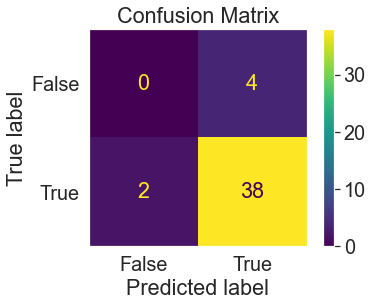

In [29]:
plt.figure(figsize=(10,10))

matrix = metrics.confusion_matrix(actual_values, predicted_values)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])

cm_display.plot()

plt.grid(False)
plt.title('Confusion Matrix')
plt.show();

**Confusion Matrix in Details**

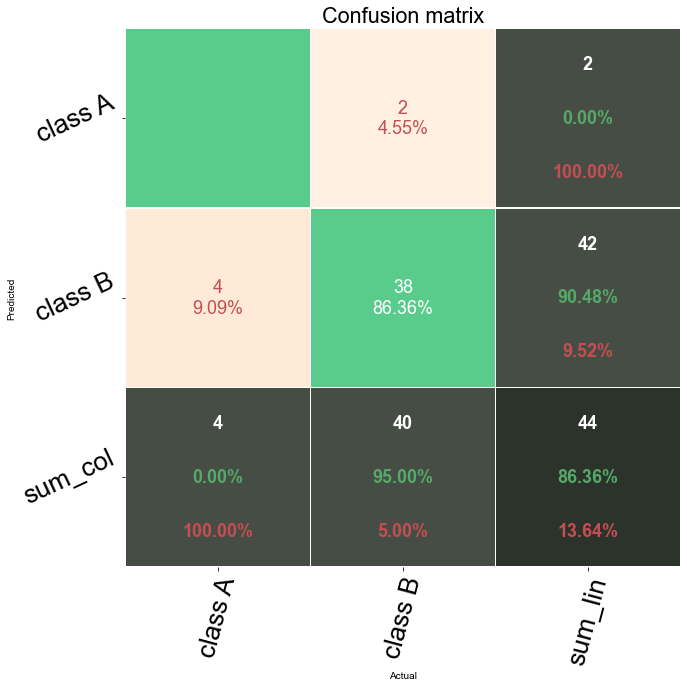

In [20]:
true_p, false_p, false_n = ut.plot_confusion_matrix_from_data(actual_values, predicted_values, fz=18, figsize=(10,10), lw=0.5)
# vertical axis = ground truth classes
# horizontal axis = predicted classes
# Background class is not taken into account in the calculation of the mean average precision.